In [331]:
import pandas as pd
import requests as rq

url = 'https://servicodados.ibge.gov.br/api/v1/localidades/estados/pa/municipios'
   
res = rq.request("GET", url)

#Creates a data frame with the Municipalities column.
if res.status_code == 200:
    df_munic = pd.DataFrame({'id': [], 'localidade': []})
    
    for id, munic in enumerate(res.json()):
        df_munic.loc[id] = [str(munic['id'])[:6], munic['nome']]


In [332]:
indicators = ['90201','90335','90358','90626','90640']

url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/1/periodos/2019/indicadores/"

# Adding indicators to the end of the url
for i, ind in enumerate(indicators):
    if i != (len(indicators)-1):
        url += ind + '|'
    else:
        url += ind + '/'
        
# Function to Formatting final url
def urlResultadosPorMunicipos(url, df):
    url += 'resultados/'    

    for i, row in df_munic.iterrows():
        if i != (len(df)-1):
            url += row.id + '|'
        else:
            url += row.id + '/'
    
    return url


url = urlResultadosPorMunicipos(url, df_munic)

# return json results
res = rq.request("GET", url)


In [333]:
if res.status_code == 200:
    
    #Scrolls through the json and inserts the data into the main dataframe for each selected indicator.
    for indicador in res.json():
        df_temp = pd.DataFrame(indicador['res'])
        df_temp = df_temp[['localidade', 'res']]
        df_temp.rename(columns = {'localidade':'id', 'res': indicador['id']}, inplace = True)
        
        #It replaces the words "Yes" and "No" with binary information 1 and 0.
        df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 if x['2019']  == 'Sim' else 0)
        df_munic = pd.merge(df_munic, df_temp, on="id")

In [334]:
df_munic['Rede_de_Protecao_assistencia'] = df_munic[90201] + df_munic[90335] + df_munic[90358] + df_munic[90626] + df_munic[90640]
df_munic = df_munic[['id', 'localidade', 'Rede_de_Protecao_assistencia']]

In [335]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/37/periodos/2010/indicadores/30255/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)

# correction of missing values
x = res.json()
x[0]['res'][73]['res']['2010'] = '0'
x

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2010': 'IDH'}, inplace=True)
df_temp = df_temp[['id', 'IDH']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [336]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/38/periodos/2019/indicadores/47001/"

url = urlResultadosPorMunicipos(url, df_munic)   
res = rq.request("GET", url)
df_temp = pd.json_normalize(res.json()[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2019': 'PIB'}, inplace=True)
df_temp = df_temp[['id', 'PIB']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [337]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/36/periodos/2003/indicadores/30252/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)
# correction of missing values
x = res.json()
x[0]['res'].append({'localidade': '150475', 'res': {'2003': '0.00'}, 'notas': {'2003': None}})

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2003': 'GINI'}, inplace=True)
df_temp = df_temp[['id', 'GINI']]
df_munic = pd.merge(df_munic, df_temp, on='id', how='left')

In [338]:
df_munic['Rede_de_Protecao_assistencia'] = pd.to_numeric(df_munic['Rede_de_Protecao_assistencia'])
df_munic['IDH'] = pd.to_numeric(df_munic['IDH'])
df_munic['PIB'] = pd.to_numeric(df_munic['PIB'])
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])

In [339]:
#cols = df_munic[['Rede_de_Protecao_assistencia', 'IDH', 'PIB', 'GINI']]

def normalize(df_columns):
    for i in df_columns:
        mx = df_munic[[i]].max()[0]
        mn = df_munic[[i]].min()[0]
        df_munic[[i]] = (df_munic[[i]] - mn) / (mx - mn)

def deNormalize(df_columns, dmin, dmax):
    for i in df_columns:
        df_munic[[i]] = df_munic[[i]] * (dmax - dmin) + dmin

#normalize(cols)
normalize(df_munic.iloc[:,2:].columns)

In [340]:
df_munic.iloc[:,2:].describe()

,Rede_de_Protecao_assistencia,IDH,PIB,GINI
count,144.000000,144.000000,144.000000,144.000000
mean,0.277778,0.774138,0.044827,0.761196
std,0.236656,0.099055,0.117906,0.081778
min,0.000000,0.000000,0.000000,0.000000
25%,0.150000,0.732909,0.010107,0.734694
50%,0.200000,0.780831,0.018945,0.775510
75%,0.400000,0.822386,0.037740,0.795918
max,1.000000,1.000000,1.000000,1.000000


In [348]:
import numpy as np
import seaborn as sns

def create_boxplot(dataset):

    Q3 = np.quantile(dataset, 0.75)
    Q1 = np.quantile(dataset, 0.25)
    IQR = Q3 - Q1

    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR

    if lower_range < 0:
        dst = df_munic.drop(df_munic[df_munic.Rede_de_Protecao_assistencia < 0.15].index)
        dst
        #dataset = dataset.drop(dataset[dataset.columns[0] < Q1].index, inplace=True)
        dataset = dataset.drop(dataset[dataset.query(dataset.columns[0] < Q1)].index, inplace=True)
        Q3 = np.quantile(dataset, 0.75)
        Q1 = np.quantile(dataset, 0.25)
        IQR = Q3 - Q1
    
        lower_range = Q1 - 1.5 * IQR
        upper_range = Q3 + 1.5 * IQR
        
    print(f"Q3 = {Q3}")
    print(f"Q1 = {Q1}")
    print(f"IQR = {IQR}")
    print(f"Lower_Range = {lower_range}")
    print(f"Upper_Range = {upper_range}")

    sns.boxplot(dataset, orient="h")


def describe_limits(dataset):
    res = np.zeros((5, 4))
    cont = 0
    for c in dataset.columns:
        Q3 = np.quantile(dataset[c], 0.75)
        M = np.quantile(dataset[c], 0.50)
        Q1 = np.quantile(dataset[c], 0.25)
        IQR = Q3 - Q1

        lower_range = Q1 - 1.5 * IQR
        upper_range = Q3 + 1.5 * IQR

        res[0][cont] = lower_range
        res[1][cont] = Q1
        res[2][cont] = M
        res[3][cont] = Q3
        res[4][cont] = upper_range

        cont += 1
    
    
    return res.tolist()
        

describe_limits(df_munic.iloc[:,2:])

[[-0.22499999999999998,
  0.5986930294906165,
  -0.03134256171445826,
  0.642857142857143],
 [0.15000000000000002,
  0.7329088471849866,
  0.010107113043029458,
  0.7346938775510204],
 [0.2, 0.7808310991957104, 0.01894514113870411, 0.7755102040816326],
 [0.4, 0.8223860589812333, 0.03774022954802127, 0.7959183673469388],
 [0.775, 0.9566018766756033, 0.07918990430550898, 0.8877551020408163]]

In [347]:
dst = df_munic.drop(df_munic[df_munic.Rede_de_Protecao_assistencia < 0.15].index)

dst


,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI
0,150010,Abaetetuba,0.8,0.841823,0.014360,0.816327
1,150013,Abel Figueiredo,0.2,0.833780,0.021286,0.755102
2,150020,Acará,0.6,0.678284,0.028919,0.734694
3,150030,Afuá,0.6,0.655496,0.014173,0.795918
4,150034,Água Azul do Norte,0.2,0.756032,0.036816,0.755102
...,...,...,...,...,...,...
137,150810,Tucuruí,1.0,0.892761,0.145617,0.816327
139,150815,Uruará,0.2,0.789544,0.028277,0.775510
141,150830,Viseu,0.2,0.690349,0.009042,0.755102
142,150835,Vitória do Xingu,0.8,0.798928,0.935595,0.775510


<AxesSubplot: ylabel='Count'>

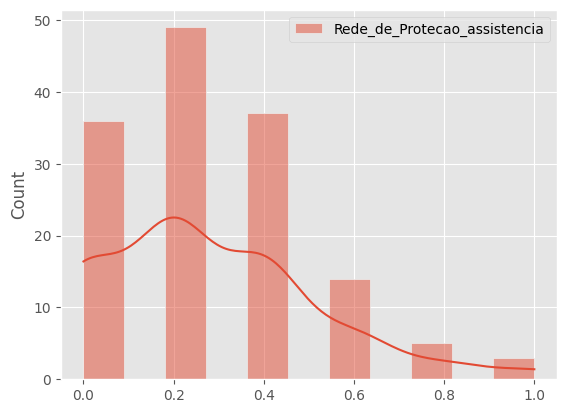

In [343]:
import seaborn as sns
sns.histplot(df_munic.iloc[:,2:3], kde=True)


In [344]:
create_boxplot(df_munic.iloc[:,2:3])

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'

<AxesSubplot: ylabel='Count'>

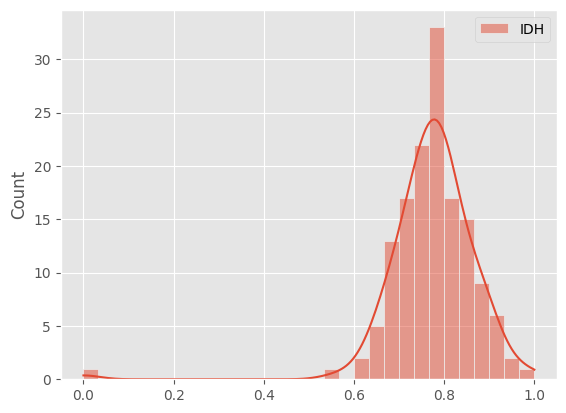

In [ ]:
sns.histplot(df_munic.iloc[:,3:4], kde=True)


Q3 = 0.8223860589812333
Q1 = 0.7329088471849866
IQR = 0.08947721179624668
Lower_Range = 0.5986930294906165
Upper_Range = 0.9566018766756033


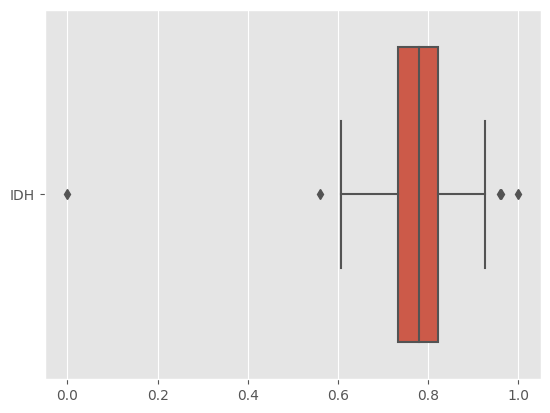

In [ ]:
create_boxplot(df_munic.iloc[:,3:4])


<AxesSubplot: ylabel='Count'>

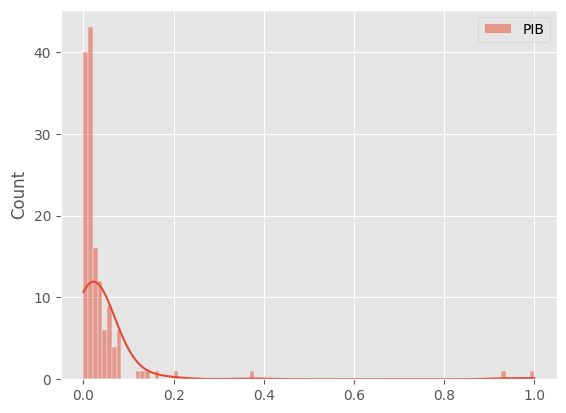

In [ ]:
sns.histplot(df_munic.iloc[:,4:5], kde=True)


Q3 = 0.03774022954802127
Q1 = 0.010107113043029458
IQR = 0.02763311650499181
Lower_Range = -0.03134256171445826
Upper_Range = 0.07918990430550898


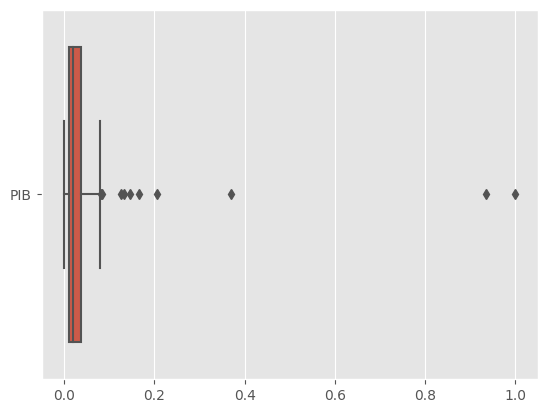

In [ ]:
create_boxplot(df_munic.iloc[:,4:5])

<AxesSubplot: ylabel='Count'>

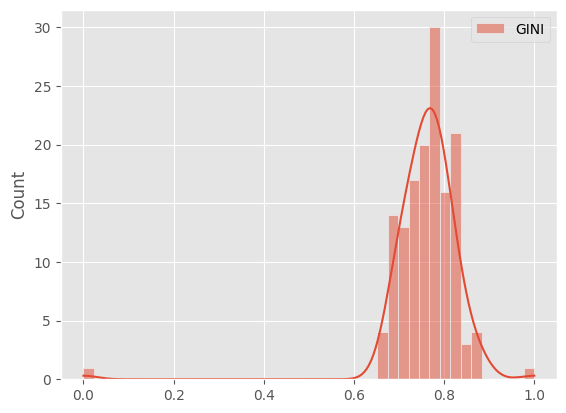

In [ ]:
sns.histplot(df_munic.iloc[:,5:6], kde=True)

Q3 = 0.7959183673469388
Q1 = 0.7346938775510204
IQR = 0.061224489795918324
Lower_Range = 0.642857142857143
Upper_Range = 0.8877551020408163


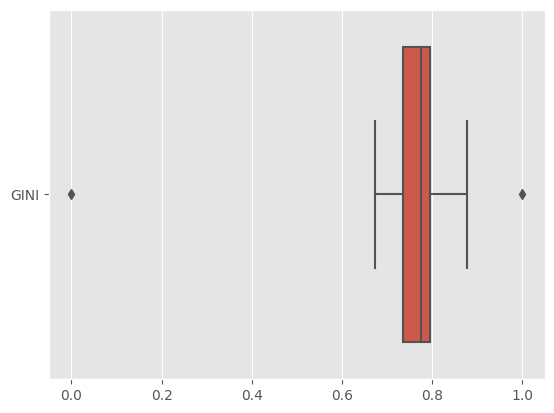

In [ ]:
create_boxplot(df_munic.iloc[:,5:6])

In [ ]:
T = df_munic.iloc[:, 2:].values


In [ ]:

import numpy as np

Z = np.around(T[:30], decimals = 4)
X = np.around(T, decimals = 4)

In [ ]:
     #IP       #IDH      #PIB      #GINI
Q = [0.05,      0.05,       0.05,      0.05]
P = [0.08,      0.08,       0.08,      0.08]
V = [2.0,      2.0,       2.0,      2.0]
W = [0.5,      0.5,       0.5,      0.5]

B = describe_limits(pd.DataFrame(X))

np.array(B)

array([[0.      , 0.598625, 0.      , 0.6429  ],
       [0.15    , 0.732875, 0.0101  , 0.7347  ],
       [0.2     , 0.78085 , 0.01895 , 0.7755  ],
       [0.4     , 0.822375, 0.03775 , 0.7959  ],
       [0.775   , 0.956625, 0.079225, 0.8877  ]])

In [ ]:
df_munic.query('PIB < 0.0101')

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,CLASS
8,150070,Anajás,0.2,0.648794,0.006700,0.734694,2
11,150090,Augusto Corrêa,0.2,0.697051,0.005867,0.816327,2
12,150095,Aurora do Pará,0.0,0.695710,0.005827,0.734694,3
13,150100,Aveiro,0.2,0.725201,0.007470,0.734694,2
14,150110,Bagre,0.2,0.631367,0.004351,0.755102,2
27,150180,Breves,0.6,0.674263,0.008677,0.816327,1
29,150195,Cachoeira do Piriá,0.0,0.634048,0.000000,0.714286,4
31,150210,Cametá,0.2,0.773458,0.010081,0.795918,1
36,150250,Chaves,0.6,0.607239,0.009919,0.693878,3
37,150260,Colares,0.4,0.806971,0.005755,0.673469,1


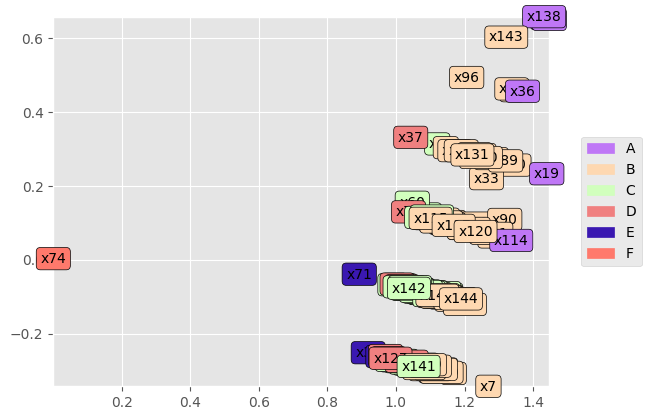

In [ ]:
from pyDecision.algorithm import electre_tri_b

classification = electre_tri_b(X, W , Q , P , V , B, cut_level = 0.7, verbose = False, rule = 'oc', graph = True)

In [ ]:
classification.count(5)

1

In [ ]:
df_munic['CLASS'] = classification

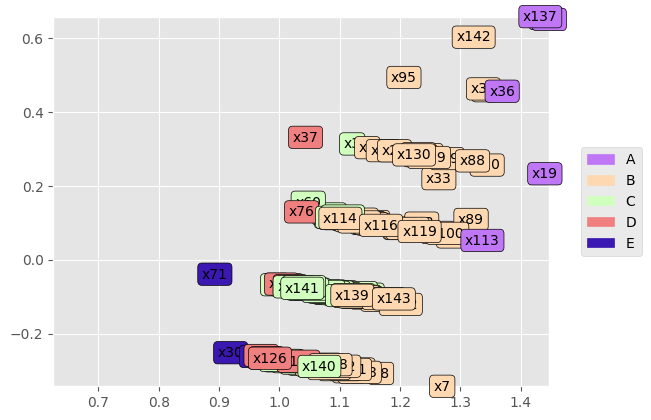

In [ ]:
df__ = df_munic.query('CLASS != 5')

df_ = df__.iloc[:, 2:6]


c = electre_tri_b(np.array(df_), W , Q , P , V , B, cut_level = 0.7, verbose = False, rule = 'oc', graph = True)


In [ ]:
np.array(df_)

array([[4.0000000e+00, 6.2800000e-01, 9.4587200e+03, 4.0000000e-01,
        1.0000000e+00],
       [1.0000000e+00, 6.2200000e-01, 1.1420760e+04, 3.7000000e-01,
        2.0000000e+00],
       [3.0000000e+00, 5.0600000e-01, 1.3582970e+04, 3.6000000e-01,
        2.0000000e+00],
       [3.0000000e+00, 4.8900000e-01, 9.4057000e+03, 3.9000000e-01,
        2.0000000e+00],
       [1.0000000e+00, 5.6400000e-01, 1.5819850e+04, 3.7000000e-01,
        2.0000000e+00],
       [0.0000000e+00, 5.6400000e-01, 1.0091010e+04, 3.9000000e-01,
        3.0000000e+00],
       [0.0000000e+00, 6.4200000e-01, 1.5930680e+04, 4.9000000e-01,
        2.0000000e+00],
       [0.0000000e+00, 6.6500000e-01, 2.4228190e+04, 4.0000000e-01,
        1.0000000e+00],
       [1.0000000e+00, 4.8400000e-01, 7.2889800e+03, 3.6000000e-01,
        4.0000000e+00],
       [3.0000000e+00, 7.1800000e-01, 1.5385550e+04, 3.8000000e-01,
        1.0000000e+00],
       [0.0000000e+00, 5.4800000e-01, 1.4888520e+04, 4.0000000e-01,
        2.00

In [ ]:
df_munic = df_munic.rename(index=lambda s: 'x' + str(s + 1))

In [ ]:
df_munic.query('CLASS == 0')

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,CLASS
x18,150130,Barcarena,5,0.662,43028.91,0.41,0
x33,150215,Canaã dos Carajás,2,0.673,288658.15,0.36,0
x42,150277,Curionópolis,2,0.636,52606.89,0.39,0
x60,150375,Jacareacanga,2,0.505,63713.36,0.34,0
x66,150420,Marabá,5,0.668,40832.03,0.41,0
x84,150530,Oriximiná,0,0.623,28531.44,0.40,0
x90,150553,Parauapebas,2,0.715,110436.99,0.39,0
x138,150810,Tucuruí,5,0.666,46639.59,0.40,0
x143,150835,Vitória do Xingu,4,0.596,270414.24,0.38,0
x144,150840,Xinguara,1,0.646,28872.41,0.39,0
